In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from gpplot import add_correlation
from core import med_log_odds_cutoff
from sklearn.linear_model import LogisticRegression
import joblib
from matplotlib_venn import venn2
from scipy import stats
import re

In [2]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [3]:
def get_percentile(x, percentile):
    x = x.dropna()
    if len(x):
        return np.percentile(x.dropna(), percentile)
    else:
        return pd.NA
    
def get_median(x):
    x = x.dropna()
    if len(x):
        return np.median(x.dropna())
    else:
        return pd.NA

In [4]:
insert_info = pd.read_csv('../data/raw/Beaker Validation Tracker 2.0 - v4.csv')
novel_insert_info = pd.read_csv('../data/raw/novel_domain_library.csv')
early_insert_info = pd.read_csv('../data/raw/Beaker Validation Tracker 2.0 - v5_rescreen.csv')
eop_data = pd.read_csv('../data/raw/24-03-28 EOP tracking - Systems.csv')
ecor_predictions = pd.read_csv('../data3/interim/ecor_predictions.csv')

/tmp/ipykernel_1354400/4063509234.py:5: DtypeWarning: Columns (24,30) have mixed types. Specify dtype option on import or set low_memory=False.
  ecor_predictions = pd.read_csv('../data3/interim/ecor_predictions.csv')


### Concatenate library info 

In [5]:
cols = ['working_id', 'genomic_accession', 'product_accessions','description', 'cloned', 'screened LB', 'fp', 'pBAD']
# random
brief_insert_info = insert_info[cols].copy()
brief_insert_info['library'] = 'random'
# novel
brief_novel_insert_info = novel_insert_info.copy()
brief_novel_insert_info = brief_novel_insert_info[[x for x in cols if x not in ['fp', 'pBAD']]].copy()
brief_novel_insert_info['library'] = 'novel'
# early
brief_early_insert_info = early_insert_info.copy()
brief_early_insert_info = brief_early_insert_info.rename(columns={'Nucleotide Accession': 'genomic_accession', 
                                                                  'Proteins': 'product_accessions'})
brief_early_insert_info[['cloned', 'screened LB']] = True, True
brief_early_insert_info = brief_early_insert_info[[x for x in cols if x not in ['fp', 'pBAD']]]
brief_early_insert_info['library'] = 'early'
# concatenate
brief_insert_info = pd.concat([brief_insert_info, brief_novel_insert_info, brief_early_insert_info]).reset_index(drop=True)
brief_insert_info['fp'] = brief_insert_info['fp'].fillna(0).astype(bool)
brief_insert_info['screened LB'] = brief_insert_info['screened LB'].fillna(False)
brief_insert_info['pBAD'] = brief_insert_info['pBAD'].fillna(False)
brief_insert_info = (brief_insert_info[brief_insert_info['screened LB'] | brief_insert_info['fp']]
                     .groupby(['product_accessions', 'genomic_accession','working_id', 'screened LB', 'fp', 'pBAD'])
                     .agg(library=('library', lambda x: ','.join(x)))
                     .reset_index())
brief_insert_info = brief_insert_info[~brief_insert_info['working_id'].isin(['AAA3', 'CRDO', 'HHHD'])]

In [6]:
brief_insert_info['random'] = brief_insert_info['library'].str.contains('random')
brief_insert_info['curated'] = brief_insert_info['library'].str.contains('early|novel')

In [7]:
exploded_insert_info = brief_insert_info.copy()
exploded_insert_info['product_accession'] = exploded_insert_info['product_accessions'].apply(lambda x: re.findall('([A-Z]+_[0-9]+\.[0-9]+)', x))
exploded_insert_info = exploded_insert_info.explode('product_accession')

In [8]:
merged_exploded_info = (exploded_insert_info.merge(ecor_predictions, 
                                                   how='inner', on=['product_accession', 'genomic_accession']))

In [9]:
keep_ids = merged_exploded_info.loc[merged_exploded_info['mean_log_odds'] > 0, 
                                    'working_id'].unique()
len(keep_ids)

94

In [10]:
filtered_merged_exploded_info = merged_exploded_info[merged_exploded_info['working_id'].isin(keep_ids)].reset_index(drop=True)

In [11]:
filtered_brief_insert_info = brief_insert_info[brief_insert_info['working_id'].isin(keep_ids)].reset_index(drop=True)

In [12]:
library_source_sum = filtered_brief_insert_info[['random', 'curated']].value_counts().reset_index()

In [13]:
library_source_sum

,random,curated,count
0,False,True,56
1,True,False,34
2,True,True,4


In [14]:
library_source_sum.query('random & ~curated')['count'].item()

34

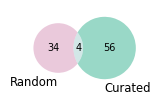

In [15]:
plt.subplots(figsize=(1.5, 1.5))
venn2(subsets={'10': library_source_sum.query('random & ~curated')['count'].item(), 
               '01': library_source_sum.query('~random & curated')['count'].item(), 
               '11': library_source_sum.query('random & curated')['count'].item()}, 
      set_labels=('Random', 'Curated'), 
      set_colors=('#CC79A7', '#009E73'))

In [16]:
merged_exploded_info['product_accession'].value_counts()

product_accession
WP_000886597.1    2
WP_000020904.1    1
WP_045232945.1    1
WP_015058250.1    1
WP_052158570.1    1
                 ..
WP_001013662.1    1
WP_001032567.1    1
WP_001057122.1    1
WP_001103754.1    1
WP_252151320.1    1
Name: count, Length: 176, dtype: int64

In [17]:
insert_predictions = (filtered_merged_exploded_info
                      .groupby(['working_id', 'genomic_accession', 'assembly'])
                      .agg(max_prediction = ('mean_log_odds', 'max'), 
                           min_prediction = ('mean_log_odds', 'min'), 
                           product_accessions = ('product_accession', lambda x: ', '.join(x)),
                           predictions=('mean_log_odds', lambda x: ', '.join([str(y) for y in x])), 
                           cds_start=('start', 'min'), 
                           cds_end=('end', 'max'), 
                           names=('name', lambda x: ', '.join(x)))
                      .reset_index())

In [18]:
insert_predictions.shape

(94, 10)

In [19]:
validated_systems = eop_data['System'].unique()

In [20]:
len(validated_systems)

42

In [21]:
merged_insert_info = (filtered_brief_insert_info.drop(columns=['product_accessions'])
                      .merge(insert_predictions, how='inner', on=['working_id', 'genomic_accession']))
merged_insert_info['defensive'] = merged_insert_info['working_id'].isin(validated_systems)
merged_insert_info['fp'] = merged_insert_info['fp'].fillna(0).astype(bool)
merged_insert_info['category'] = pd.Categorical(['Validated defense' if x else 'Not validated' for x in merged_insert_info['defensive']], 
                                                categories=['Validated defense', 'Not validated'])
merged_insert_info = (merged_insert_info
                      .sort_values('max_prediction', ascending=False)
                      .reset_index(drop=True))


In [22]:
merged_insert_info.shape

(94, 18)

In [23]:
merged_insert_info.query('random')['defensive'].mean()

0.42105263157894735

In [24]:
merged_insert_info.query('curated & ~random')['defensive'].mean()

0.4642857142857143

In [25]:
merged_insert_info['category'].value_counts()

category
Not validated        52
Validated defense    42
Name: count, dtype: int64

In [26]:
(merged_insert_info['category'] == 'Validated defense').sum()/len(merged_insert_info)

0.44680851063829785

### Estimate validation rate

In [27]:
min_tpr_window = 5


In [28]:
precision_list = list()
for i, row in merged_insert_info.iterrows():
    if (i+1) >= min_tpr_window:
        filtered_merged_insert_info = merged_insert_info.iloc[0:(i+1), :]
        precision = filtered_merged_insert_info['defensive'].mean()
        precision_list.append(precision)
    else:
        precision_list.append(np.nan)

In [29]:
merged_insert_info['precision'] = precision_list

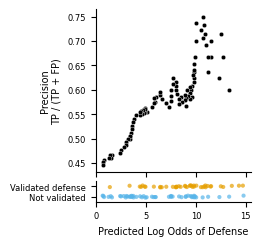

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[4,0.5], figsize=(2,2.5), sharex=True)
fig.subplots_adjust(hspace=0.1)
sns.scatterplot(data=merged_insert_info, 
                x='max_prediction', y='precision', ax=ax1, color='black', s=10)
sns.stripplot(data=merged_insert_info, y='category', x='max_prediction', 
              ax=ax2, orient='h', alpha=0.7, hue='defensive', legend=False, 
              palette=['#56b4e9', '#e69f00'], jitter=True, dodge=False, s=3)
ax1.set_ylabel('Precision\nTP / (TP + FP)')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted Log Odds of Defense')
sns.despine()
#plt.xlim(merged_insert_info['max_prediction'].max() + 0.5, -0.5)
plt.savefig('../figures/estimated_precision.svg', dpi=300, bbox_inches='tight')

In [31]:
top_preds = merged_insert_info.sort_values('max_prediction', ascending=False).head(n=len(merged_insert_info)//2)
bottom_preds = merged_insert_info.sort_values('max_prediction', ascending=True).head(n=len(merged_insert_info)//2)
print(top_preds['defensive'].mean())
print(bottom_preds['defensive'].mean())


0.6170212765957447
0.2765957446808511


In [32]:
log_odds_width = 4

In [33]:
ref_points = merged_insert_info['max_prediction']
n_resamples = 1_000
range_def_frac_list = list()
neighbor_dist = log_odds_width/2
min_pts = 10
for i in tqdm(range(n_resamples)):
    resampled_df = merged_insert_info.sample(frac=1, replace=True, random_state=i)
    for mid_pt in ref_points:
        min_log_odds = mid_pt - neighbor_dist
        max_log_odds = mid_pt + neighbor_dist
        relevant_pts = resampled_df.loc[(resampled_df['max_prediction'] > min_log_odds) & 
                                        (resampled_df['max_prediction'] < max_log_odds)]
        n_pts = len(relevant_pts)
        if n_pts > min_pts:
            defensive_ratio = relevant_pts['defensive'].mean()
            range_def_frac_list.append({'trial': i, 
                                        'frac_defensive': defensive_ratio, 
                                        'n_pts': n_pts, 
                                        'mid_pt': mid_pt})
        

100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


In [34]:
range_def_frac_df = pd.DataFrame(range_def_frac_list)
range_def_frac_sum = (range_def_frac_df.groupby('mid_pt')
                      .agg(precision_top=('frac_defensive', lambda x: get_percentile(x, 97.5)),
                           precision_bottom=('frac_defensive', lambda x: get_percentile(x, 2.5)), 
                           precision_median=('frac_defensive', lambda x: get_median(x)),
                           std_defense=('frac_defensive', 'std'), 
                           mean_n = ('n_pts', 'mean'), 
                           total_trials=('trial', 'nunique'))
                      .reset_index())

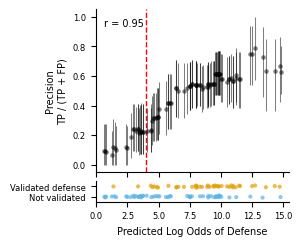

In [35]:
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[4,0.5], figsize=(2.5,2.5), sharex=True)
fig.subplots_adjust(hspace=0.1)
ax1.errorbar(x=range_def_frac_sum['mid_pt'], y=range_def_frac_sum['precision_median'], 
             yerr=[range_def_frac_sum['precision_median'] - range_def_frac_sum['precision_bottom'], 
                   range_def_frac_sum['precision_top'] - range_def_frac_sum['precision_median']], 
             capsize=0, color='black', ms=6.5, elinewidth=0.75, fmt='.', alpha=0.5, markeredgewidth=0)
add_correlation(data=range_def_frac_sum, x='mid_pt', y='precision_median', ax=ax1, fontfamily='Sans-Serif')
ax1.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='red', zorder=0, linewidth=1)
sns.stripplot(data=merged_insert_info, y='category', x='max_prediction', 
              ax=ax2, orient='h', alpha=0.7, hue='defensive', legend=False, 
              palette=['#56b4e9', '#e69f00'], jitter=True, dodge=False, s=3)
sns.despine()
ax1.set_ylabel('Precision\nTP / (TP + FP)')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted Log Odds of Defense')
plt.savefig('../figures/estimated_precision.svg', dpi=600, bbox_inches='tight')

In [36]:
range_def_frac_sum

,mid_pt,precision_top,precision_bottom,precision_median,std_defense,mean_n,total_trials
0,0.649643,0.272727,0.000000,0.090909,0.084489,12.629139,302
1,0.717826,0.272727,0.000000,0.090909,0.084489,12.629139,302
2,0.788151,0.272727,0.000000,0.083333,0.079653,13.022989,435
3,1.247071,0.230769,0.000000,0.066667,0.069660,14.522581,775
4,1.371814,0.307692,0.000000,0.117647,0.083511,15.909193,892
...,...,...,...,...,...,...,...
89,13.338104,0.928571,0.454545,0.727273,0.125417,12.878860,421
90,13.604509,0.846154,0.363636,0.636364,0.123237,12.057143,175
91,14.318119,0.846154,0.363636,0.636364,0.123237,12.057143,175
92,14.712791,0.861742,0.420455,0.667582,0.136771,12.038462,26


In [37]:
stats.pearsonr(range_def_frac_sum['mid_pt'], 
               range_def_frac_sum['precision_median'])

PearsonRResult(statistic=0.948976297506597, pvalue=6.756381700364129e-48)

In [38]:
merged_insert_info.loc[merged_insert_info['max_prediction'] < med_log_odds_cutoff, 'defensive'].mean()

0.09523809523809523

In [39]:
merged_insert_info.loc[(merged_insert_info['max_prediction'] > med_log_odds_cutoff), 'defensive'].mean()

0.547945205479452

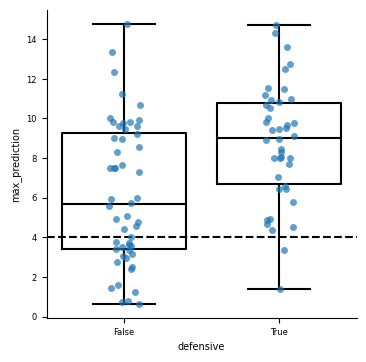

In [40]:
plt.subplots(figsize=(4,4))
sns.boxplot(data=merged_insert_info, x='defensive', y='max_prediction', fill=False, 
            color='black')
sns.stripplot(data=merged_insert_info, x='defensive', y='max_prediction', 
              alpha=0.7,  jitter=True, dodge=False)
plt.axhline(y=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()

In [41]:
merged_insert_info.drop(columns='precision').to_csv('../data3/interim/all_library_info.csv', index=False)